<a href="https://www.youtube.com/watch?v=G7jYn3dlYKw&list=PLxqBkZuBynVS8mDTc8ZGermXiS-32pR2y&index=42&ab_channel=Rohan-Paul-AI"><h1 style="font-size:250%; font-family:cursive; color:#ff6666;"><b>Link YouTube Video - Bitcoin Price Prediction with FB Prophet | Time Series with Machine Learning </b></h1></a>

[![IMAGE ALT TEXT](https://imgur.com/bSCFF9M.png)](https://www.youtube.com/watch?v=G7jYn3dlYKw&list=PLxqBkZuBynVS8mDTc8ZGermXiS-32pR2y&index=42&ab_channel=Rohan-Paul-AI)



----------------

### [Link to Kaggle competition and Dataset](https://www.kaggle.com/competitions/jpx-tokyo-stock-exchange-prediction/overview)


This competition will involve building portfolios from the stocks eligible for predictions. Specifically, each participant ranks the stocks from highest to lowest expected returns and is evaluated on the difference in returns between the top and bottom 200 stocks. You'll have access to financial data from the Japanese market, such as stock information and historical stock prices to train and test your model. After the training phase is complete, the competition will compare your models against real future returns.

The training data begins in January 2017 with about 1,860 stocks with new stocks added through December 2020 for a total of 2,000 stocks. Below is a brief overview and descriptive statistics of the variables in the training data. 

In [1]:
import warnings, gc
import numpy as np 
import pandas as pd
import matplotlib.colors
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.offline import init_notebook_mode
from datetime import datetime, timedelta
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error,mean_absolute_error
from lightgbm import LGBMRegressor
from decimal import ROUND_HALF_UP, Decimal
warnings.filterwarnings("ignore")
import plotly.figure_factory as ff
import matplotlib.pyplot as plt 

In [2]:
# ROOT_DIR = "../input/jpx-tokyo-stock-exchange-prediction/"
ROOT_DIR = "../input/"

In [3]:


temp = dict(layout=go.Layout(font=dict(family="Franklin Gothic", size=12), width=800))

colors=px.colors.qualitative.Plotly

train=pd.read_csv(ROOT_DIR + "train_files/stock_prices.csv", parse_dates=['Date'])

stock_list=pd.read_csv(ROOT_DIR + "stock_list.csv")

print("The training data begins on {} and ends on {}.\n".format(train.Date.min(),train.Date.max()))

display(train.describe().style.format('{:,.2f}'))

The training data begins on 2017-01-04 00:00:00 and ends on 2021-12-03 00:00:00.



In [4]:
train.head()

RowId       Date  SecuritiesCode    Open    High     Low   Close   
0  20170104_1301 2017-01-04            1301  2734.0  2755.0  2730.0  2742.0  \
1  20170104_1332 2017-01-04            1332   568.0   576.0   563.0   571.0   
2  20170104_1333 2017-01-04            1333  3150.0  3210.0  3140.0  3210.0   
3  20170104_1376 2017-01-04            1376  1510.0  1550.0  1510.0  1550.0   
4  20170104_1377 2017-01-04            1377  3270.0  3350.0  3270.0  3330.0   

    Volume  AdjustmentFactor  ExpectedDividend  SupervisionFlag    Target  
0    31400               1.0               NaN            False  0.000730  
1  2798500               1.0               NaN            False  0.012324  
2   270800               1.0               NaN            False  0.006154  
3    11300               1.0               NaN            False  0.011053  
4   150800               1.0               NaN            False  0.003026

<div style="background: linear-gradient(45deg, #FFC300, #FF5733, #C70039, #900C3F); padding: 10px; border-radius: 5px; display: flex; align-items: center;">
    <h3 style="font-weight: bold; color: white; margin: 0 auto;"> Mean and Standard Deviation Distribution of 'Target' column </h3>
</div>

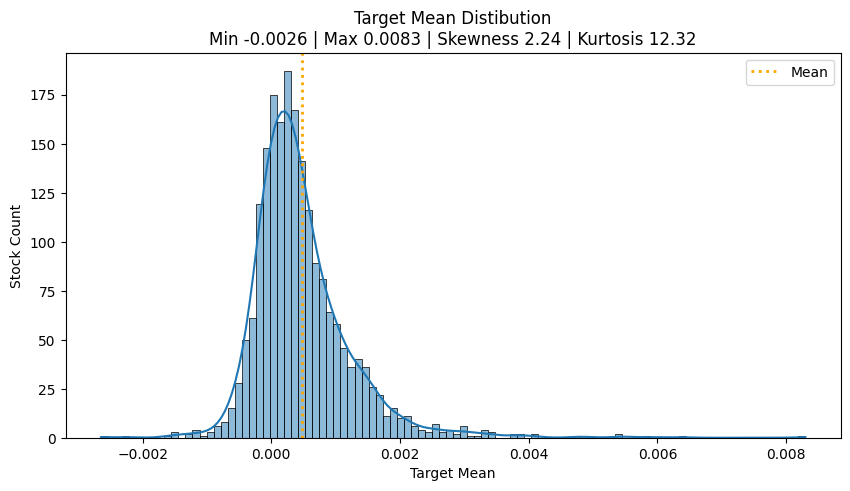

In [5]:
target_mean_per_stock = train.groupby(['SecuritiesCode'])['Target'].mean()

target_mean_mean = target_mean_per_stock.mean()

fig, ax = plt.subplots(figsize=(10, 5))
sns.histplot(data=target_mean_per_stock.values, bins=100, palette=colors, kde=True,
             ax=ax)
ax.axvline(x=target_mean_mean, color='orange', linestyle='dotted', linewidth=2, 
           label='Mean')
ax.set_title("Target Mean Distibution\n"
             f"Min {round(target_mean_per_stock.min(), 4)} | "
             f"Max {round(target_mean_per_stock.max(), 4)} | "
             f"Skewness {round(target_mean_per_stock.skew(), 2)} | "
             f"Kurtosis {round(target_mean_per_stock.kurtosis(), 2)}")
ax.set_xlabel("Target Mean")
ax.set_ylabel("Stock Count")
ax.legend()
plt.show()

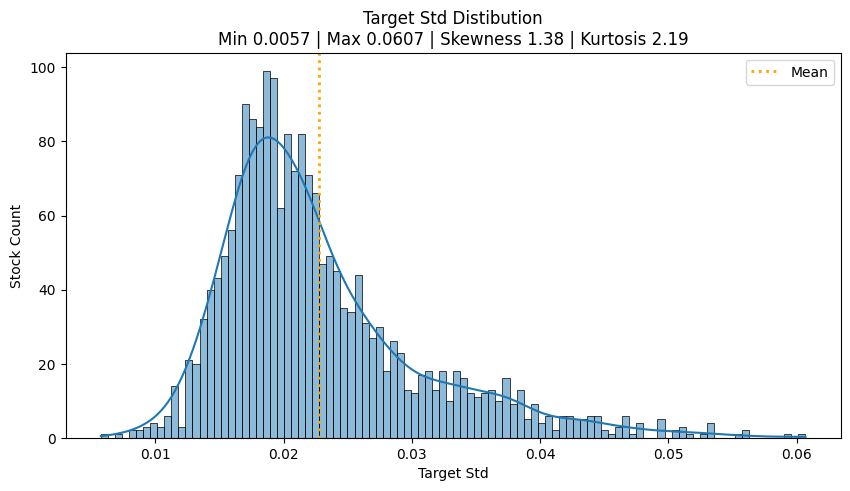

In [6]:
target_std_per_stock = train.groupby(['SecuritiesCode'])['Target'].std()

target_std_mean = target_std_per_stock.mean()

fig, ax = plt.subplots(figsize=(10, 5))
sns.histplot(data=target_std_per_stock.values, bins=100, palette=colors, kde=True,
             ax=ax)
ax.axvline(x=target_std_mean, color='orange', linestyle='dotted', linewidth=2, 
           label='Mean')
ax.set_title("Target Std Distibution\n"
             f"Min {round(target_std_per_stock.min(), 4)} | "
             f"Max {round(target_std_per_stock.max(), 4)} | "
             f"Skewness {round(target_std_per_stock.skew(), 2)} | "
             f"Kurtosis {round(target_std_per_stock.kurtosis(), 2)}")
ax.set_xlabel("Target Std")
ax.set_ylabel("Stock Count")
ax.legend()
plt.show()

In Plotly, update_xaxes is a method used to update the layout of the x-axis in a plot

The graphs above show the market's average stock return, closing price, and shares traded since January 2017. While there has been much fluctuation over the past four years, the number of shares traded has slightly decreased from the volume in early 2017.

-------------------

<div style="background: linear-gradient(45deg, #FFC300, #FF5733, #C70039, #900C3F); padding: 10px; border-radius: 5px; display: flex; align-items: center;">
    <h3 style="font-weight: bold; color: white; margin: 0 auto;"> EDA - Yearly Average Stock Returns by Sector </h3>
</div>



In [7]:
stock_list.head(2)

SecuritiesCode  EffectiveDate              Name          Section/Products   
0            1301       20211230  KYOKUYO CO.,LTD.  First Section (Domestic)  \
1            1305       20211230   Daiwa ETF-TOPIX                ETFs/ ETNs   

  NewMarketSegment 33SectorCode                       33SectorName   
0     Prime Market           50  Fishery, Agriculture and Forestry  \
1              NaN            -                                  -   

  17SectorCode 17SectorName NewIndexSeriesSizeCode NewIndexSeriesSize   
0            1       FOODS                       7      TOPIX Small 2  \
1            -            -                      -                  -   

    TradeDate   Close  IssuedShares  MarketCapitalization  Universe0  
0  20211230.0  3080.0  1.092828e+07          3.365911e+10       True  
1  20211230.0  2097.0  3.634636e+09          7.621831e+12      False

In [8]:
train.head(2)

RowId       Date  SecuritiesCode    Open    High     Low   Close   
0  20170104_1301 2017-01-04            1301  2734.0  2755.0  2730.0  2742.0  \
1  20170104_1332 2017-01-04            1332   568.0   576.0   563.0   571.0   

    Volume  AdjustmentFactor  ExpectedDividend  SupervisionFlag    Target  
0    31400               1.0               NaN            False  0.000730  
1  2798500               1.0               NaN            False  0.012324

**Target column as per specification** => Change ratio of adjusted closing price between t+2 and t+1 where t+0 is TradeDate

In [9]:
def process_stock_list(stock_list):
    stock_list['SectorName'] = [i.rstrip().lower().capitalize() for i in stock_list['17SectorName']]
    stock_list['Name'] = [i.rstrip().lower().capitalize() for i in stock_list['Name']]
    return stock_list

def merge_train_stock(train, stock_list):
    train_df = train.merge(stock_list[['SecuritiesCode', 'Name', 'SectorName']], on='SecuritiesCode', how='left')
    train_df['Year'] = train_df['Date'].dt.year
    return train_df

def get_yearly_avg_returns(train_df):
    years = {year: pd.DataFrame() for year in train_df.Year.unique()[::-1]}
    # Above creates a dictionary years where each key is a unique year in the train_df DataFrame, and the corresponding value is an empty DataFrame. The years are sorted in descending order because of the [::-1] slicing operation to reverser the list.

    # Enter a loop over the keys of the years dictionary, i.e., over the unique years. 
    for key in years.keys():
        # For each year, it does the following:
        # First filters train_df to keep only the rows where the year is the current year (df = train_df[train_df.Year == key]).
        df = train_df[train_df.Year == key]        
        years[key] = df.groupby('SectorName')['Target'].mean().mul(100).rename("Avg_return_{}".format(key))
        # Above groups the filtered DataFrame by the sector and calculates the mean of the Target column, which represents the return of the stocks, multiplies it by 100 to convert it to percentage, and renames it as "Avg_return_" followed by the year. The result is a Series that is then stored in the years dictionary under the key of the current year 
    
    df = pd.concat((years[i].to_frame() for i in years.keys()), axis=1)
    # Above concatenates the Series in the years dictionary into a single DataFrame, df, where each column represents the average return for a year, and each row represents a sector
    df = df.sort_values(by="Avg_return_2021")
    return df


def add_bar_trace(fig, x, df, mask, col, index, color):
    """ this function is used to add to the figure a bar graph that represents the average return of the stocks in each sector for a specific year. 
    The bars are separated by whether the return is positive or negative, indicated by the mask parameter. 
    If the return is positive, the bar is green, and if it is negative, the bar is red. 
    The orientation of the bars is horizontal, and the sectors are displayed on the y-axis. The text on each bar shows the average return in percentage format, and the hover text provides more details about the average return in the sector. 
    The trace is named by the year of the return, extracted from the last 4 characters of col. """
    fig.add_trace(go.Bar(x=x[mask], y=df.index[mask], orientation='h',
                         text=x[mask], texttemplate='%{text:.2f}%', textposition='auto',
                         hovertemplate='Average Return in %{y} Stocks = %{x:.4f}%',
                         marker=dict(color=color, opacity=0.7), name=col[-4:]),
                  row=1, col=index + 1)

def create_yearly_avg_returns_plot(df, template):
    fig = make_subplots(rows=1, cols=5, shared_yaxes=True)
    
    for i, col in enumerate(df.columns):
        # Here each col represents a unique year
        x = df[col]
        mask = x <= 0 # For explanation see below
        add_bar_trace(fig, x, df, mask, col, i, 'red')
        add_bar_trace(fig, x, df, ~mask, col, i, 'green')
        
        fig.update_xaxes(range=(x.min() - .15, x.max() + .15),
                         title='{} Returns'.format(col[-4:]),
                         showticklabels=False, row=1, col=i + 1)
        """ range=(x.min() - .15, x.max() + .15): This sets the range of the x-axis for the current subplot. It is set to be slightly wider than the range of the data by subtracting 0.15 from the minimum value and adding 0.15 to the maximum value. This provides some padding around the data to make the plot easier to read and aesthetically pleasing. 
        
        row=1, col=i + 1: These specify the position of the subplot that is being updated. The plot is a grid of subplots and this specifies which subplot's x-axis properties are being updated. row=1 specifies the first row and col=i + 1 specifies the column based on the loop index i (1-indexed).
        """
    
    fig.update_layout(template=template, title='Yearly Average Stock Returns by Sector',
                      hovermode='closest', margin=dict(l=250, r=50),
                      height=600, width=1000, showlegend=False)
    fig.show()
    
""" Explanation of the line mask = x <= 0 
the line mask = x <= 0 is used to create a boolean mask for the x Series, which contains the average returns for a given year. 
This mask has True values for elements in x that are less than or equal to 0 and False values for elements greater than 0.

The purpose of creating this mask is to separate the bars in the plot into two categories based on their average returns:

Bars with negative or zero returns (red bars), which are identified using the mask.
Bars with positive returns (green bars), which are identified using the inverse of the mask (~mask).
By using this mask, the function can create two separate bar traces for each year, one for negative or zero returns and another for positive returns, with different colors for better visualization.
"""
    
######################################################


stock_list = process_stock_list(stock_list)
train_df = merge_train_stock(train, stock_list)

print(train_df.columns)

Index(['RowId', 'Date', 'SecuritiesCode', 'Open', 'High', 'Low', 'Close',
       'Volume', 'AdjustmentFactor', 'ExpectedDividend', 'SupervisionFlag',
       'Target', 'Name', 'SectorName', 'Year'],
      dtype='object')


In [10]:
train_df.head(2)

RowId       Date  SecuritiesCode    Open    High     Low   Close   
0  20170104_1301 2017-01-04            1301  2734.0  2755.0  2730.0  2742.0  \
1  20170104_1332 2017-01-04            1332   568.0   576.0   563.0   571.0   

    Volume  AdjustmentFactor  ExpectedDividend  SupervisionFlag    Target   
0    31400               1.0               NaN            False  0.000730  \
1  2798500               1.0               NaN            False  0.012324   

                        Name SectorName  Year  
0           Kyokuyo co.,ltd.      Foods  2017  
1  Nippon suisan kaisha,ltd.      Foods  2017

In [11]:
yearly_avg_returns_df = get_yearly_avg_returns(train_df)
yearly_avg_returns_df.head(2)

Avg_return_2021  Avg_return_2020  Avg_return_2019   
SectorName                                                                
Pharmaceutical              -0.012243         0.014959         0.076435  \
Electric power & gas        -0.005676         0.005496         0.003795   

                      Avg_return_2018  Avg_return_2017  
SectorName                                              
Pharmaceutical              -0.006922         0.121417  
Electric power & gas         0.046056        -0.000536

In [12]:
create_yearly_avg_returns_plot(yearly_avg_returns_df, temp)


In 2021, nearly all industries saw a positive return on average, with the highest in Energy Resources at about 0.13% overall, while in 2018, all sectors saw a negative return except for Electric Power & Gas. 

Since some of the stocks were added in December 2020, I will use the data filtered after this date so that the data will consist of 231 days of stock prices for all 2,000 stocks.

In [13]:
train_df=train_df[train_df.Date>'2020-12-23']
print("New Train Shape {}.\nMissing values in Target = {}".format(train_df.shape,train_df['Target'].isna().sum()))

New Train Shape (462000, 15).
Missing values in Target = 0


<div style="background: linear-gradient(45deg, #FFC300, #FF5733, #C70039, #900C3F); padding: 10px; border-radius: 5px; display: flex; align-items: center;">
    <h3 style="font-weight: bold; color: white; margin: 0 auto;">Distribution of the "Target" by Sectors | Box Plots</h3>
</div>

In [14]:
""" generate a color palette with a specified number of distinct colors. These colors are then used to differentiate different sectors when visualizing the target distribution by sector. """
def create_color_palette(num_colors):
    return ['hsl(' + str(h) + ',50%,50%)' for h in np.linspace(0, 360, num_colors)]

""" linear spacing, which generates evenly spaced values over a specified range. Here, it is creating num_colors number of values between 0 and 360. These values will be used as the hue (h) for the HSL color model. 

hsl( : This stands for Hue, Saturation, Lightness color model. It's a way to represent colors.

Hue (h) is the degree on the color wheel from 0 to 360. 0 is red, 120 is green, 240 is blue.

Saturation (s) is a percentage value; 0% means a shade of gray and 100% is the full color.

Lightness (l) is also a percentage; 0% is black, 100% is white.

'hsl(' + str(h) + ',50%,50%)': This is creating a string representation of a color in the HSL color space. For each value h generated by np.linspace(0, 360, num_colors), it is creating a color with that hue and a saturation and lightness of 50%. The resulting list of colors will be evenly distributed around the color wheel, providing a variety of colors for the plot.

"""

def create_target_distribution_plot(train_df, yearly_avg_returns_df, template):
    fig = go.Figure()
    color_palette = create_color_palette(len(yearly_avg_returns_df.index))
    
    for i, sector in enumerate(yearly_avg_returns_df.index[::-1]):
        y_data = train_df[train_df['SectorName'] == sector]['Target']
        add_box_trace(fig, y_data, sector, color_palette[i])
    
    fig.update_layout(template=template, title='Target Distribution by Sector',
                      yaxis=dict(title='Stock Return', ticksuffix='%'),
                      margin=dict(b=150), height=750, width=900)
    fig.show()

def add_box_trace(fig, y_data, sector, color):
    fig.add_trace(go.Box(y=y_data * 100, name=sector,
                         marker_color=color, showlegend=False))
""" y_data: This is the data that will be represented by the box plot. In this case, it's the 'Target' data for a particular sector.

name: This argument sets the name or label for the box plot trace. The sector variable is being used as the name, which suggests that the box plot represents data related to a specific sector or category.

marker_color: This argument determines the color of the box plot. The color variable is being used to specify the color. The color variable likely contains a color value in a format recognized by Plotly, such as a hexadecimal color code or a named color. """

create_target_distribution_plot(train_df, yearly_avg_returns_df, temp)


While most sectors have returns between 4% and -4%, there are quite a few outliers across all industries, with some returns as high as 62% in Commercial & Wholesale Trade and others as low as -31% in IT & Services sector. 

In the charts above, the boxes represent the daily spread between the open and close prices and the lines represent the spread between the low and high prices. The color of the boxes indicates whether the close price was greater or lower than the open price, with green indicating a higher closing price on that day and red indicating a lower closing price. 

<div style="background: linear-gradient(45deg, #FFC300, #FF5733, #C70039, #900C3F); padding: 10px; border-radius: 5px; display: flex; align-items: center;">
    <h3 style="font-weight: bold; color: white; margin: 0 auto;"> Stocks with Highest and Lowest Return by Sector</h3>
</div>

In [15]:
train_df.head(2)

RowId       Date  SecuritiesCode    Open    High     Low   
1870531  20201224_1301 2020-12-24            1301  2913.0  2937.0  2909.0  \
1870532  20201224_1332 2020-12-24            1332   421.0   426.0   419.0   

          Close   Volume  AdjustmentFactor  ExpectedDividend  SupervisionFlag   
1870531  2917.0    13900               1.0               NaN            False  \
1870532   420.0  1385000               1.0               NaN            False   

           Target                       Name SectorName  Year  
1870531  0.011660           Kyokuyo co.,ltd.      Foods  2020  
1870532 -0.007092  Nippon suisan kaisha,ltd.      Foods  2020

In [16]:
def get_stocks(train_df):
    """ Function to identify the best and worst performing stocks both overall and within each sector.  """
    
    # First, for "ALL" sectors get stocks with the 7 highest and 7 lowest average returns (calculated over the 'Target' column) for each sector
    stock = train_df.groupby('Name')['Target'].mean().mul(100)
    stock_low = stock.nsmallest(7)[::-1].rename("Return")
    """ returning the 7 smallest values i.e. 7 stocks with the lowest average return, calculated previously as the mean of the 'Target' column  
    [::-1]: for reversing a list or array. When applied to a pandas DataFrame or Series, it will reverse the order of the rows. So, in this case, it's changing the order of the 7 stocks with the lowest returns from ascending to descending.
    """
    stock_high = stock.nlargest(7).rename("Return")
    
    stock = pd.concat([stock_high, stock_low], axis=0).reset_index()
    """ Here, axis=0 means that the function will concatenate along the index (or row-wise). In other words, stock_low will be appended at the end of stock_high, resulting in a new DataFrame that includes both the highest and lowest return stocks, one after the other. The result will be a longer DataFrame with the same columns as the original two. The stock_high entries will be on top, followed by the stock_low entries. 
    
    reset_index() function resets the index of the DataFrame to the default integer index (0, 1, 2, 3, …, n),  because after concatenating the two DataFrames, the index can be disordered or based on the indices from the original DataFrames. By resetting the index, you ensure that the new DataFrame has a clean and easy-to-understand index.    """
    
    # assign the string 'All' to a new 'Sector' column in the stock DataFrame. This label indicates that these stocks are the overall highest and lowest, regardless of sector.
    stock['Sector'] = 'All'
    
    # Now do the same for each sector. i.e. for each Individual sectors, get the stocks with the 7 highest and 7 lowest average returns (calculated over the 'Target' column) for that particular sector.
    for i in train_df.SectorName.unique():
        sector = train_df[train_df.SectorName == i].groupby('Name')['Target'].mean().mul(100)
        stock_low = sector.nsmallest(7)[::-1].rename("Return")
        stock_high = sector.nlargest(7).rename("Return")
        sector_stock = pd.concat([stock_high, stock_low], axis=0).reset_index()
        sector_stock['Sector'] = i
        stock = pd.concat([stock, sector_stock], ignore_index=True)
    
    return stock

def create_bar_trace(x, y, sector, visible, color):
    return go.Bar(x=x, y=y, text=y,
                  texttemplate='%{text:.2f}%',
                  textposition='auto',
                  name=sector, visible=visible,
                  hovertemplate='%{x} average return: %{y:.3f}%',
                  marker=dict(color=color, opacity=0.7))

def create_button(sector, visibility):
    return dict(label=sector,
                method="update",
                args=[{"visible": visibility}])

def create_plot(stock, template):
    """
    This function creates a Plotly figure that displays the stocks with the highest 
    and lowest returns by sector. The figure includes a dropdown menu that allows the 
    user to select which sector's data they want to visualize.
    
    Parameters:
    stock (pd.DataFrame): A DataFrame containing the names, average returns, and sectors 
    of the stocks to be plotted.
    template (str): The Plotly template to be used for the figure.
    """
    fig = go.Figure()
    buttons = []
    
    # For each unique sector in the stock DataFrame...
    for i, sector in enumerate(stock.Sector.unique()):
        x = stock[stock.Sector == sector]['Name']
        y = stock[stock.Sector == sector]['Return']
        mask = y > 0
        
        fig.add_trace(create_bar_trace(x[mask], y[mask], sector, (False if i != 0 else True), 'green'))
        fig.add_trace(create_bar_trace(x[~mask], y[~mask], sector, (False if i != 0 else True), 'red'))
        
        # Initializing the entire visibility list to False, to define the default state in which all traces in the plot are initially hidden.
        visibility = [False] * 2 * len(stock.Sector.unique())
        
        # Then updating two specific values in the visibility list, setting them to True.
        # This means that for each sector, two corresponding traces are set to be visible.
        visibility[i * 2], visibility[i * 2 + 1] = True, True
        
        buttons.append(create_button(sector, visibility))
    
    fig.update_layout(title='Stocks with Highest and Lowest Returns by Sector',
                      template=template, yaxis=dict(title='Average Return', ticksuffix='%'),
                      updatemenus=[dict(active=0, type="dropdown",
                                        buttons=buttons, xanchor='left',
                                        yanchor='bottom', y=1.01, x=.01)],
                      margin=dict(b=150), showlegend=False, height=700, width=900)
    fig.show()

stock = get_stocks(train_df)
stock.head(2)

Name    Return Sector
0     Enechange ltd.  0.752303    All
1  For startups,inc.  0.751935    All

## Explanations on why `mask = y > 0` is used in create_plot() method.


The line mask = y > 0 is creating a boolean mask for the 'Return' values of the stocks. This mask is a pandas Series of the same length as y (which is the Series of 'Return' values for a particular sector), but instead of numerical values, it contains True or False for each item in the Series.

In this case, mask will be True for every stock that had a positive average return and False for every stock that had a negative or zero average return. 

Why is this useful? The primary reason is that it allows for the separation of the stocks with positive and negative returns. This is used in the next lines of the create_plot() function, which add a trace to the plot for each group of stocks:

```py
fig.add_trace(create_bar_trace(x[mask], y[mask], sector, (False if i != 0 else True), 'green'))
fig.add_trace(create_bar_trace(x[~mask], y[~mask], sector, (False if i != 0 else True), 'red'))

```

Here, x[mask] and y[mask] are the names and returns, respectively, of the stocks with positive returns (since mask is True for these stocks). These are plotted as green bars on the plot. 

Conversely, x[~mask] and y[~mask] are the names and returns of the stocks with negative or zero returns, and these are plotted as red bars.

---------------------

## Explanation for `visibility = [False] * 2 * len(stock.Sector.unique())`

These are part of the process of creating interactive buttons for the plot, which allow the user to switch between visualizing the stocks of different sectors. This is made possible through the use of the 'updatemenus' attribute of the Plotly figure layout.


`visibility = [False] * 2 * len(stock.Sector.unique())` => 

The first line is creating a list of boolean values, all set to False, that will represent the visibility status of each trace in the figure. Each sector's data is represented by two traces (one for stocks with positive returns and one for stocks with negative returns), and there are `len(stock.Sector.unique())` sectors. So the total number of traces is `2 * len(stock.Sector.unique())`, and hence the length of the visibility list is also `2 * len(stock.Sector.unique())`.

`visibility[i * 2], visibility[i * 2 + 1] = True, True` => 

The second line is updating two specific values in the visibility list, setting them to True. The indices being updated are i * 2 and i * 2 + 1, where i is the current index in the loop over sectors. This means that for each sector, two corresponding traces are set to be visible.

The logic behind this is that when a user selects a sector using the dropdown menu, only the traces corresponding to that sector should be visible, while all other traces should be hidden. This is achieved by creating a separate visibility list for each button, where all values are False except for those corresponding to the traces of the sector associated with that button.

In the final figure, each button in the dropdown menu is associated with a unique visibility list. When a button is clicked, the visibility attribute of all traces is updated according to the associated visibility list, effectively showing only the traces associated with that button and hiding all others.

In [17]:

create_plot(stock, temp)

Among stocks with the highest return on average since December 2020, 6 of the 7 were in the IT & Services sector and one was in the Pharmaceutical sector. The IT & Services and Pharmaceutical sectors also make up 6 of the stocks with the lowest returns on average.

<div style="background: linear-gradient(45deg, #FFC300, #FF5733, #C70039, #900C3F); padding: 10px; border-radius: 5px; display: flex; align-items: center;">
    <h3 style="font-weight: bold; color: white; margin: 0 auto;"> EDA - MOST Correlated Stocks </h3>
</div>

In [18]:
corr_test = train_df.groupby('SecuritiesCode')[[ 'Target', 'Close' ]].corr()

In [19]:
corr_test.head()

Target     Close
SecuritiesCode                           
1301           Target  1.000000 -0.194596
               Close  -0.194596  1.000000
1332           Target  1.000000 -0.134643
               Close  -0.134643  1.000000
1333           Target  1.000000 -0.155567

In [20]:
corr_test.head()

Target     Close
SecuritiesCode                           
1301           Target  1.000000 -0.194596
               Close  -0.194596  1.000000
1332           Target  1.000000 -0.134643
               Close  -0.134643  1.000000
1333           Target  1.000000 -0.155567

In [21]:
def get_most_correlated_stocks(train_df, n=10):
    """
    Get the n most correlated stocks with the target variable in the given DataFrame.
    
    :param train_df: DataFrame containing stock data
    :param n: Number of most correlated stocks to return
    :return: DataFrame containing the n most correlated stocks with their correlation values
    """
    corr = train_df.groupby('SecuritiesCode')[['Target', 'Close']].corr().unstack().iloc[:, 1]
    stocks = corr.nlargest(n).rename("Return").reset_index()
    stocks = stocks.merge(train_df[['Name', 'SecuritiesCode']], on='SecuritiesCode').drop_duplicates()
    return stocks
""" 
Explanation of each part of below line

corr = train_df.groupby('SecuritiesCode')[['Target', 'Close']].corr().unstack().iloc[:, 1]

[['Target', 'Close']].corr(): This operation calculates the correlation between the Target and Close columns for each grouped DataFrame (i.e., for each stock). 

The corr() method returns a correlation matrix, which is a square matrix that contains the correlation coefficients between each pair of variables. Since we only have two variables (Target and Close), our correlation matrix will be 2x2 for each group. 

The main diagonal (from the top left to the bottom right) of this matrix will always contain 1s, because each variable is perfectly correlated with itself. The other two values (on the off-diagonal) are the correlation between Target and Close, and they will be the same because correlation is symmetric.

######################## unstack():  #################################

.unstack(): This operation reshapes the resulting DataFrame. It "pivots" a level of the (possibly hierarchical) column labels and turns them into row indices, producing a new, "unstacked" DataFrame.

So why exactly unstack() was used here => When you apply the corr() method after grouping by SecuritiesCode in the DataFrame, you get a MultiIndex DataFrame as a result. The MultiIndex DataFrame has two levels of row indices: the SecuritiesCode and the variables Target and Close. The columns also have two levels: again Target and Close.

It will look like this

SecuritiesCode                  
Stock_A         Target  Close
                Target  1.000000  0.921423
                Close   0.921423  1.000000
Stock_B         Target  1.000000  0.754342
                Close   0.754342  1.000000
...


Here, you can see that the correlation of Target with itself and Close with itself (the 1.000000 entries) are redundant, as are the correlations of Close with Target (they are equal to the correlation of Target with Close).

The goal is to have a Series or DataFrame where each SecuritiesCode is associated with the correlation between its Target and Close values. To achieve this, the unstack() method is used to pivot one of the levels of the column labels (which are also Target and Close) and make them part of the index.

After using unstack(), the DataFrame would look something like this:

                 Target               Close
SecuritiesCode  Target  Close       Target   Close
Stock_A          1.000000  0.921423   0.921423  1.000000
Stock_B          1.000000  0.754342   0.754342  1.000000
...

Then, iloc[:, 1] is used to select the second column of this DataFrame, which is the correlation of Close with Target.

So, the use of unstack() here is a way to restructure the result of the corr() method, so that it's easier to select the desired correlations.

#########################################################


.iloc[:, 1]: This operation selects the second column of the unstacked DataFrame. Recall that the correlation matrix was a 2x2 matrix. When this matrix is unstacked, it creates a multi-level DataFrame with 2 columns. The first column (iloc[:, 0]) would correspond to the correlation of Target with itself (always 1), and the second column (iloc[:, 1]) would correspond to the correlation of Close with Target (which is what we're interested in). 

After this line, corr is a Series where the index is the SecuritiesCode and the value is the correlation between the Target and Close values for that stock.
"""

def create_color_palette(num_colors):
    """
    Create a color palette of the specified number of colors using the seaborn library.
    
    :param num_colors: Number of colors to generate
    :return: List of RGBA color strings
    """
    pal = sns.color_palette("magma_r", num_colors).as_hex()
    return ['rgba' + str(matplotlib.colors.to_rgba(i, 0.7)) for i in pal]

def create_most_correlated_stocks_plot(stocks, template):
    """
    Create and show a bar plot of the most correlated stocks with the target variable.
    
    :param stocks: DataFrame containing the most correlated stocks with their correlation values
    :param template: Plotly template to use for the plot
    """
    fig = go.Figure()
    rgb = create_color_palette(len(stocks))
    add_bar_trace(fig, stocks, rgb)
    
    fig.update_layout(template=template, title='Most Correlated Stocks with Target Variable',
                      yaxis=dict(title='Correlation', showticklabels=False),
                      xaxis=dict(title='Stock', tickangle=45), margin=dict(b=100),
                      width=800, height=500)
    fig.show()

def add_bar_trace(fig, stocks, colors):
    """
    Add a bar trace to the given figure for the most correlated stocks.
    
    :param fig: Plotly figure object
    :param stocks: DataFrame containing the most correlated stocks with their correlation values
    :param colors: List of RGBA color strings
    """
    fig.add_trace(go.Bar(x=stocks.Name, y=stocks.Return, text=stocks.Return,
                         texttemplate='%{text:.2f}', name='', width=0.8,
                         textposition='outside', marker=dict(color=colors, line=dict(color=colors, width=1)),
                         hovertemplate='Correlation of %{x} with target = %{y:.3f}'))

most_correlated_stocks = get_most_correlated_stocks(train_df)

create_most_correlated_stocks_plot(most_correlated_stocks, temp)


<div style="background: linear-gradient(45deg, #FFC300, #FF5733, #C70039, #900C3F); padding: 10px; border-radius: 5px; display: flex; align-items: center;">
    <h3 style="font-weight: bold; color: white; margin: 0 auto;"> Heatmap with Stock Correlations between Sectors </h3>
</div>

In [22]:
train_df.head(2)

RowId       Date  SecuritiesCode    Open    High     Low   
1870531  20201224_1301 2020-12-24            1301  2913.0  2937.0  2909.0  \
1870532  20201224_1332 2020-12-24            1332   421.0   426.0   419.0   

          Close   Volume  AdjustmentFactor  ExpectedDividend  SupervisionFlag   
1870531  2917.0    13900               1.0               NaN            False  \
1870532   420.0  1385000               1.0               NaN            False   

           Target                       Name SectorName  Year  
1870531  0.011660           Kyokuyo co.,ltd.      Foods  2020  
1870532 -0.007092  Nippon suisan kaisha,ltd.      Foods  2020

In [23]:
pv = train_df.pivot_table(index='Date', columns='SectorName', values='Close').reset_index()
pv.head(2)

SectorName       Date  Automobiles & transportation equipment        Banks   
0          2020-12-24                              2060.16875  1159.420312  \
1          2020-12-25                              2075.73750  1164.456250   

SectorName  Commercial & wholesale trade  Construction & materials   
0                            2175.799329               2351.531847  \
1                            2232.221192               2335.558065   

SectorName  Electric appliances & precision instruments  Electric power & gas   
0                                           3488.671958           1816.352174  \
1                                           3501.230159           1820.195652   

SectorName  Energy resources  Financials （ex banks）        Foods   
0                1571.842857            1666.819298  2971.840426  \
1                1583.571429            1677.135088  2992.236559   

SectorName  It & services, others    Machinery  Pharmaceutical   
0                     3153.555672  3207.281250     2838.063830  \
1                     3154.033403  3218.484375     2824.095745   

SectorName  Raw materials & chemicals  Real estate  Retail trade   
0                         2949.537059  1659.152174   3025.044693  \
1                         2967.362573  1680.297101   3029.441341   

SectorName  Steel & nonferrous metals  Transportation & logistics  
0                         1871.022727                 2737.007042  
1                         1877.079545                 2762.422535

In [24]:
def create_pivot_table(train_df):
    """
    Create a pivot table from the given DataFrame.
    
    :param train_df: DataFrame containing stock data
    :return: Pivot table with Date as index, SectorName as columns, and Close as values
    """
    return train_df.pivot_table(index='Date', columns='SectorName', values='Close').reset_index()

""" The pivot table function takes in a data frame and the parameters detailing the shape you want the data to take. Then it outputs summarized data in the form of a pivot table.
index='Date': This sets 'Date' as the index of the pivot table. This means that each row in the output table will correspond to a unique date found in the 'Date' column of the input DataFrame.

columns='SectorName': This sets 'SectorName' as the columns of the pivot table. This means that each column in the output table will correspond to a unique sector name found in the 'SectorName' column of the input DataFrame.

values='Close': This specifies that the values in the pivot table should be taken from the 'Close' column of the input DataFrame. If there are multiple 'Close' values for the same date and sector, these will be aggregated (by default, using the mean).

The result of the pivot_table function is a new DataFrame, with each row representing a unique date, and each column representing a unique sector. The intersection of a row and a column will contain the corresponding 'Close' value for that date and sector. .

"""

def calculate_correlation_mask(corr):
    """
    Calculate the mask for the correlation matrix.
    
    :param corr: Correlation matrix
    :return: Masked correlation matrix
    """
    mask = np.triu(np.ones_like(corr, dtype=bool))
    c_mask = np.where(~mask, corr, 100)
    return c_mask
""" The line mask = np.triu(np.ones_like(corr, dtype=bool)) creates an upper triangular boolean mask that is later used to filter the correlation matrix.

np.ones_like(corr, dtype=bool): This creates a new array of the same shape as the input array corr, filled with boolean True values.
The dtype=bool argument ensures that the output array has a boolean data type.

np.triu(): This function returns the upper triangle of an array. In this case, it takes the boolean array created in the previous step as input. 
The output is a new boolean array where the elements below the main diagonal are replaced with False.
The triu() function takes the following parameter values:

m: This represents the array_like object or the input array.
k: Defauls to 0. This represents the diagonal above or below the main diagonal. K < 0 is below the main diagonal, and k>0 is above the main diagonal. This is optional.

The purpose of creating this upper triangular boolean mask is to remove the redundant lower triangular part of the correlation matrix, as well as the diagonal (since the correlation of a variable with itself is always 1). This is done to make the heatmap plot more concise and easier to read by showing only the unique correlations between different sectors.
-----------

np.where(~mask, corr, 100) => 

After creating this mask, it is used in the calculate_correlation_mask() function to set the lower triangular part of the correlation matrix to the value 100. This is done to differentiate these values from the actual correlation coefficients, which will always be between -1 and 1. Later, the extract_correlation_values() function removes these 100 values and only keeps the unique correlation coefficients in the final heatmap plot. """

####################################


def extract_correlation_values(c_mask):
    """
    Extract correlation values from the masked correlation matrix.
    
    :param c_mask: Masked correlation matrix
    :return: List of correlation values
    """
    # print("c_mask ", c_mask)
    cor = []
    for i in c_mask.tolist()[1:]:
        cor.append([x for x in i if x != 100])
    # print("cor[::-1] ", cor[::-1])
    return cor[::-1]
    
    # return cor
""" we are doing c_mask.tolist()[1:] => We use slicing [1:] to exclude the first row, which corresponds to the row with the value of 100 (that we previously set in the calculate_correlation_mask() function). By doing this, we ignore the first row because it contains no meaningful correlation data. The remaining rows represent the unique correlations between different sectors.

To chek it if you print c_mask => The first row is - [ 1.0e+02  1.0e+02  1.0e+02  1.0e+02  1.0e+02  1.0e+02  1.0e+02  1.0e+02
   1.0e+02  1.0e+02  1.0e+02  1.0e+02  1.0e+02  1.0e+02  1.0e+02  1.0e+02  1.0e+02]

The notation "1.0e+02" represents 100. In this notation, "1.0" is the significand or mantissa, "e" stands for "times ten to the power of", and "+02" is the exponent. So, "1.0e+02" means 1.0 times 10 to the power of 2, which is equivalent to 100.

Why  cor[::-1] => This operation reverses the order of the list cor. The reversal is needed because when we create the cor list by iterating through the c_mask, we append rows in the original order, and the heatmap plot displays them from top to bottom. By reversing the list, we make sure that the sectors are displayed in the correct order in the heatmap plot.
And also in the below method the overall shape matches with z=cor 
"""

############################################

def create_correlation_heatmap_plot(train_df, template):
    """
    Create and show a heatmap plot of the stock correlation between sectors.
    
    :param train_df: DataFrame containing stock data
    :param template: Plotly template to use for the plot
    """
    df_pivot = create_pivot_table(train_df)
    # Drop 'Date' column before calculating correlation
    # otherwise it will be included in one of the column for the correlation matrix
    df_pivot = df_pivot.drop(columns=['Date'])
    corr = df_pivot.corr().round(2)
    
    c_mask = calculate_correlation_mask(corr)
    cor = extract_correlation_values(c_mask)
    
    print('corr.index.tolist ', corr.index.tolist())
    x = corr.index.tolist()[:-1]
    y = corr.columns.tolist()[1:][::-1]
    
    fig = ff.create_annotated_heatmap(z=cor, x=x, y=y,
                                      hovertemplate='Correlation between %{x} and %{y} stocks = %{z}',
                                      colorscale='viridis', name='')
    
    fig.update_layout(template=template, title='Stock Correlation between Sectors',
                      margin=dict(l=250, t=270), height=800, width=900,
                      yaxis=dict(showgrid=False, autorange='reversed'),
                      xaxis=dict(showgrid=False))
    fig.show()
    
    """ Explanation of 
    x = corr.index.tolist()[:-1]
    y = corr.columns.tolist()[1:][::-1] 
    
    x = corr.index.tolist()[:-1]: This line creates the x-axis labels for the heatmap plot. Since you've already dropped the 'Date' column, corr.index returns the index labels of the corr DataFrame, which are the names of the sectors. By using the slice notation [:-1], we exclude the last sector name in the list. This is done because the last sector name will not have a corresponding y-axis label due to the slice notation [1:] used for the y-axis labels (explained below). Therefore, we exclude it from the x-axis labels to maintain consistency in the plot.

    y = corr.columns.tolist()[1:][::-1]: This line creates the y-axis labels for the heatmap. corr.columns returns the column labels of the corr DataFrame, which are the names of the sectors. By using the slice notation [1:], we exclude the first sector name in the list, to avoid duplicating the correlation value of the first sector with itself on the heatmap plot, as this value is always 1 and doesn't provide additional information. Finally, we use the slice notation [::-1] to reverse the order of the remaining sector names.
    
    """

create_correlation_heatmap_plot(train_df, temp)

corr.index.tolist  ['Automobiles & transportation equipment', 'Banks', 'Commercial & wholesale trade', 'Construction & materials', 'Electric appliances & precision instruments', 'Electric power & gas', 'Energy resources', 'Financials （ex banks）', 'Foods', 'It & services, others', 'Machinery', 'Pharmaceutical', 'Raw materials & chemicals', 'Real estate', 'Retail trade', 'Steel & nonferrous metals', 'Transportation & logistics']


<div style="background: linear-gradient(45deg, #FFC300, #FF5733, #C70039, #900C3F); padding: 10px; border-radius: 5px; display: flex; align-items: center;">
    <h3 style="font-weight: bold; color: white; margin: 0 auto;"> Generating AdjustedClose price to account for any stock splits or reverse splits </h3>
</div>


Source of this method - https://www.kaggle.com/code/smeitoma/train-demo?scriptVersionId=92137850&cellId=5

We will generate AdjustedClose using AdjustmentFactor value. This should reduce historical price gap caused by split/reverse-split.

Using the stock's adjusted close price, I will create a set of new features, including the stock price moving average, exponential moving average, return, and volatility, each over a period of 5, 10, 20, 30, and 50 days.

In [25]:
def adjust_price(price):
    """
    Args:
        price (pd.DataFrame)  : pd.DataFrame include stock_price
    Returns:
        price DataFrame (pd.DataFrame): stock_price with generated AdjustedClose
    """
    # transform Date column into datetime
    price.loc[: ,"Date"] = pd.to_datetime(price.loc[: ,"Date"], format="%Y-%m-%d")

    def generate_adjusted_close(df):
        """
        Args:
            df (pd.DataFrame)  : stock_price for a single SecuritiesCode
        Returns:
            df (pd.DataFrame): stock_price with AdjustedClose for a single SecuritiesCode
        """
        # sort data to generate CumulativeAdjustmentFactor
        df = df.sort_values("Date", ascending=False)
        
        # generate CumulativeAdjustmentFactor - this will be a new column name
        df.loc[:, "CumulativeAdjustmentFactor"] = df["AdjustmentFactor"].cumprod()
        
        # generate AdjustedClose - this will be a new column name
        df.loc[:, "AdjustedClose"] = (
            df["CumulativeAdjustmentFactor"] * df["Close"]
        ).map(lambda x: float(
            Decimal(str(x)).quantize(Decimal('0.1'), rounding=ROUND_HALF_UP)
        ))
        """ df.loc[:, "AdjustedClose"]: Selects all rows (using the colon) and the "AdjustedClose" column in the DataFrame df. 
        The .loc[] indexer allows for label-based indexing of the DataFrame. 
        
        df["CumulativeAdjustmentFactor"] * df["Close"]: Here we are multiplying the "CumulativeAdjustmentFactor" column with the "Close" column element-wise. This operation results in a new Series where each element corresponds to the product of these two columns for each respective row.
        
        .map(lambda x: float(...)): => The .map() function is applied to the resulting Series, which applies a given function to each element in the Series. 
        Inside the lambda function, the Decimal class is used to improve the precision and avoid potential floating-point errors. The str(x) converts the input value x to a string, and the Decimal() constructor creates a new Decimal object from this string. 
        
        The .quantize() method is then applied to this Decimal object, rounding it to the nearest 0.1 (specified by the Decimal('0.1') argument).
        
        The rounding parameter is set to ROUND_HALF_UP, which is a common rounding mode, rounding to the nearest integer value, with half-way values (e.g., 0.5) rounded up.
        float(...): => Finally, the result of the lambda function is converted back to a floating-point number using the float() function.        
        """
        # reverse order
        df = df.sort_values("Date")
        # Before applying forward-fill method to the AdjustedClose column, need to replace 0 into np.nan
        df.loc[df["AdjustedClose"] == 0, "AdjustedClose"] = np.nan
        # forward fill AdjustedClose
        df.loc[:, "AdjustedClose"] = df.loc[:, "AdjustedClose"].ffill()
        #The forward-fill method is used to fill missing values (e.g., NaN) in the Series or DataFrame. 
        # It propagates the last observed non-null value forward until another non-null value is 
        return df
    
    # generate AdjustedClose
    price = price.sort_values(["SecuritiesCode", "Date"])
    price = price.groupby("SecuritiesCode").apply(generate_adjusted_close).reset_index(drop=True)
    return price

train=train.drop('ExpectedDividend',axis=1).fillna(0)

prices = adjust_price(train)

In [26]:
prices.head()

RowId       Date  SecuritiesCode    Open    High     Low   Close   
0  20170104_1301 2017-01-04            1301  2734.0  2755.0  2730.0  2742.0  \
1  20170105_1301 2017-01-05            1301  2743.0  2747.0  2735.0  2738.0   
2  20170106_1301 2017-01-06            1301  2734.0  2744.0  2720.0  2740.0   
3  20170110_1301 2017-01-10            1301  2745.0  2754.0  2735.0  2748.0   
4  20170111_1301 2017-01-11            1301  2748.0  2752.0  2737.0  2745.0   

   Volume  AdjustmentFactor  SupervisionFlag    Target   
0   31400               1.0            False  0.000730  \
1   17900               1.0            False  0.002920   
2   19900               1.0            False -0.001092   
3   24200               1.0            False -0.005100   
4    9300               1.0            False -0.003295   

   CumulativeAdjustmentFactor  AdjustedClose  
0                         1.0         2742.0  
1                         1.0         2738.0  
2                         1.0         2740.0  
3                         1.0         2748.0  
4                         1.0         2745.0

<div style="background: linear-gradient(45deg, #FFC300, #FF5733, #C70039, #900C3F); padding: 10px; border-radius: 5px; display: flex; align-items: center;">
    <h3 style="font-weight: bold; color: white; margin: 0 auto;"> Feature Engineering </h3>
</div>



In [27]:
"""  The OBV is a momentum indicator that uses volume flow to predict changes in stock price.
On-balance volume provides a running total of an asset's trading volume and indicates whether this volume is flowing in or out of a given security or currency pair. The OBV is a cumulative total of volume (positive and negative). There are three rules implemented when calculating the OBV. They are:

1. If today's closing price is higher than yesterday's closing price, then: Current OBV = Previous OBV + today's volume

2. If today's closing price is lower than yesterday's closing price, then: Current OBV = Previous OBV - today's volume

3. If today's closing price equals yesterday's closing price, then: Current OBV = Previous OBV
"""
def on_balance_volume(df, col, col_volume):
    df['Return_1Day_for_obv'] = df[col].pct_change()
    df['OBV'] = (np.sign(df['Return_1Day_for_obv']).fillna(0) * df[col_volume]).cumsum()
    """ np.sign(df['Return_1Day_for_obv']): np.sign() calculates the sign of the values in the column Return_1Day_for_obv. This operation will result in -1 for negative returns, 0 for no change, and 1 for positive returns.
    
    * df[col_volume]: This multiplies the sign of the daily return by the corresponding day's trading volume. The idea is that if the return was positive (1), the volume for that day contributes positively to the OBV, and if the return was negative (-1), the volume for that day contributes negatively.
    
    .cumsum(): it is used to add up all the daily volume contributions calculated in the previous step, from the start of the data to the current day. The result is the On-Balance Volume series, which indicates volume flow and potentially future price movements.
    
    """
    df = df.drop(columns=['Return_1Day_for_obv'])
    return df

""" ATR is typically derived from the 14-day simple moving average of a series of true range indicators.

The True Range for today is the greatest of the following:

Today's high minus today's low
The absolute value of today's high minus yesterday's close
The absolute value of today's low minus yesterday's close """

def average_true_range(df, high, low, close, n=14):
    data = df.copy()
    high_low = data[high] - data[low]
    high_close = np.abs(data[high] - data[close].shift())
    low_close = np.abs(data[low] - data[close].shift())
    ranges = pd.concat([high_low, high_close, low_close], axis=1)
    true_range = np.max(ranges, axis=1)
    atr = true_range.rolling(n).sum()/n
    df['ATR'] = atr
    return df

""" The Money Flow Index (MFI) is a momentum indicator that measures the flow of money into and out of a security over a specified period of time. It is related to the Relative Strength Index (RSI) but incorporates volume, whereas the RSI only considers price.  """
def money_flow_index(df, high, low, close, volume, n=14):
    # First, the period's Typical Price is calculated. Typical Price = (High + Low + Close)/3
    typical_price = (df[high] + df[low] + df[close])/3
    
    #Next, Money Flow (not the Money Flow Index) is calculated by multiplying the period's Typical Price by the volume. Money Flow = Typical Price * Volume
    money_flow = typical_price * df[volume]
    
    positive_flow = money_flow.where(typical_price > typical_price.shift(1), 0)
    """ Above line compares the typical price of the current day with the typical price of the previous day. 
    typical_price.shift(1) is shifting the typical_price series "down" by one, effectively moving each day's typical price to the next day's position.
    So after the typical_price.shift(1) => the current index position's typical_price would effectively be that of the previous day.  
    Hence with this shift(1) operation => we are comparing each day's typical price with the previous day's typical price.     
    The result is a boolean series where True indicates that the typical price has increased compared to the previous day, and False indicates it has decreased or stayed the same. """
    negative_flow = money_flow.where(typical_price < typical_price.shift(1), 0)
    
    #Calculate the money flow ratio by adding up all the positive money flows over the last 14 periods and dividing it by the negative money flows for the last 14 periods.
    money_flow_ratio = positive_flow.rolling(n).sum() / negative_flow.rolling(n).sum()
    MFI = 100 - (100/(1+money_flow_ratio))
    df['MFI'] = MFI
    return df

# For RSI => This code will NOT work with series
# will get "KeyError: 'AdjustedClose'" 
""" def relative_strength_index(df, col, period):
    delta = df[col].diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    
    avg_gain = gain.rolling(window=period).mean()
    avg_loss = loss.rolling(window=period).mean()
    
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi """

def relative_strength_index(series, period):
    delta = series.diff()
    """  Above line calculates the difference between each element in the given series (price data) and its preceding element. This results in a new Series with the first element being NaN (as there is no previous element for the first data point), and the remaining elements represent the difference in price between consecutive data points. This operation essentially computes the period-to-period price change. """
    gain = delta.where(delta > 0, 0)
    """ new Series gain, contains only the positive values from the delta Series, representing the increases in price. The .where() function checks if each element in delta is greater than 0, and if it is, it keeps the original value; otherwise, it replaces the value with 0. This way, we obtain a Series with gains only, while the losses are replaced with 0. """
    loss = -delta.where(delta < 0, 0)
    """Similary, new Series loss, contains only the negative values from the delta Series, representing the decreases in price. The .where() function checks if each element in delta is less than 0, and if it is, it keeps the original value; otherwise, it replaces the value with 0. Since we need to work with positive values for losses, we apply a negation (- sign) in front of delta to turn the negative values into positive values. This way, we obtain a Series with losses only, while the gains are replaced with 0.  """    

    avg_gain = gain.rolling(window=period).mean()
    avg_loss = loss.rolling(window=period).mean()

    # RS = Average Gain over the specified period / Average Loss over the specified period
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi
""" The RSI value will range from 0 to 100. Generally, an RSI of 70 or above indicates that a stock is becoming overbought or overvalued and may be primed for a trend reversal or corrective pullback in price. An RSI reading of 30 or below indicates an oversold or undervalued condition. """


' The RSI value will range from 0 to 100. Generally, an RSI of 70 or above indicates that a stock is becoming overbought or overvalued and may be primed for a trend reversal or corrective pullback in price. An RSI reading of 30 or below indicates an oversold or undervalued condition. '

In [28]:
def create_features(df):
    """
    This function calculates and adds various technical features to the input DataFrame, such as returns, moving averages, 
    exponential moving averages, and volatility for specified periods. The function assumes that the input DataFrame contains
    columns named 'AdjustedClose' and 'SecuritiesCode'.
    
    Parameters:
    df (pandas.DataFrame): The input DataFrame containing historical stock data with columns 'AdjustedClose' and 'SecuritiesCode'.
    
    Returns:
    pandas.DataFrame: The output DataFrame with additional feature columns.
    """

    # Create a copy of the input DataFrame to avoid modifying the original data
    df = df.copy()

    # Define the column of interest and the periods for which to calculate features
    col = 'AdjustedClose'
    col_volume = 'Volume'  # Assume that your DataFrame has a 'Volume' column
    col_high = 'High'  # Assume that your DataFrame has a 'High' column
    col_low = 'Low'  # Assume that your DataFrame has a 'Low' column
    periods = [5, 10, 20, 30, 50]

    # Loop through each period and calculate features
    for period in periods:
        # Calculate the percentage change in AdjustedClose for each period and add a new column to the DataFrame
        df.loc[:, "Return_{}Day".format(period)] = df.groupby("SecuritiesCode")[col].pct_change(period)

        # Calculate the rolling mean of AdjustedClose for each period and add a new column to the DataFrame
        df.loc[:, "MovingAvg_{}Day".format(period)] = df.groupby("SecuritiesCode")[col].rolling(window=period).mean().values

        # Calculate the exponentially weighted moving average of AdjustedClose for each period and add a new column to the DataFrame
        df.loc[:, "ExpMovingAvg_{}Day".format(period)] = df.groupby("SecuritiesCode")[col].ewm(span=period, adjust=False).mean().values

        # Calculate the rolling volatility for each period (using log returns) and add a new column to the DataFrame
        df.loc[:, "Volatility_{}Day".format(period)] = np.log(df[col]).groupby(df["SecuritiesCode"]).diff().rolling(period).std()
        # print(df.columns)
        
        # Add some more Technical Features => RSI + MACD + "MACD_Signal" + "BollingerUpper_{}Day" + "BollingerLower_{}Day"
        # df.loc[:, "RSI_{}Day".format(period)] = df.groupby("SecuritiesCode")[col].apply(lambda x: relative_strength_index(x, col, period))
        # Above line will NOT work with series, it was giving "KeyError: 'AdjustedClose'"
        df["RSI_{}Day".format(period)] = df.groupby("SecuritiesCode")[col].apply(lambda x: relative_strength_index(x, period)).reset_index(level=0, drop=True)

        # Calculate MACD and MACD Signal
        ema_short = df.groupby("SecuritiesCode")[col].ewm(span=12, adjust=False).mean().values
        ema_long = df.groupby("SecuritiesCode")[col].ewm(span=26, adjust=False).mean().values
        
        df.loc[:, "MACD"] = ema_short - ema_long
        df.loc[:, "MACD_Signal"] = df["MACD"].ewm(span=9, adjust=False).mean().values

        # Calculate Bollinger Bands
        rolling_mean = df.groupby("SecuritiesCode")[col].rolling(window=period).mean().values
        rolling_std = df.groupby("SecuritiesCode")[col].rolling(window=period).std().values
        
        df.loc[:, "BollingerUpper_{}Day".format(period)] = rolling_mean + (2 * rolling_std)
        df.loc[:, "BollingerLower_{}Day".format(period)] = rolling_mean - (2 * rolling_std)
        
        df = on_balance_volume(df, col, col_volume)
        df = average_true_range(df, col_high, col_low, col, period)
        df = money_flow_index(df, col_high, col_low, col, col_volume, period)

    return df


price_features=create_features(df=prices)

price_features.drop(['RowId','SupervisionFlag','AdjustmentFactor','CumulativeAdjustmentFactor','Close'],axis=1,inplace=True)

In [29]:
price_features.columns

Index(['Date', 'SecuritiesCode', 'Open', 'High', 'Low', 'Volume', 'Target',
       'AdjustedClose', 'Return_5Day', 'MovingAvg_5Day', 'ExpMovingAvg_5Day',
       'Volatility_5Day', 'RSI_5Day', 'MACD', 'MACD_Signal',
       'BollingerUpper_5Day', 'BollingerLower_5Day', 'OBV', 'ATR', 'MFI',
       'Return_10Day', 'MovingAvg_10Day', 'ExpMovingAvg_10Day',
       'Volatility_10Day', 'RSI_10Day', 'BollingerUpper_10Day',
       'BollingerLower_10Day', 'Return_20Day', 'MovingAvg_20Day',
       'ExpMovingAvg_20Day', 'Volatility_20Day', 'RSI_20Day',
       'BollingerUpper_20Day', 'BollingerLower_20Day', 'Return_30Day',
       'MovingAvg_30Day', 'ExpMovingAvg_30Day', 'Volatility_30Day',
       'RSI_30Day', 'BollingerUpper_30Day', 'BollingerLower_30Day',
       'Return_50Day', 'MovingAvg_50Day', 'ExpMovingAvg_50Day',
       'Volatility_50Day', 'RSI_50Day', 'BollingerUpper_50Day',
       'BollingerLower_50Day'],
      dtype='object')

<div style="background: linear-gradient(45deg, #FFC300, #FF5733, #C70039, #900C3F); padding: 10px; border-radius: 5px; display: flex; align-items: center;">
    <h3 style="font-weight: bold; color: white; margin: 0 auto;"> Price Prediction </h3>
</div>





Submissions for this competition are evaluated based on the [Sharpe Ratio](https://en.wikipedia.org/wiki/Sharpe_ratio) of the daily spread of returns. For each forecast day, all active stocks will be ranked in order of their predicted return. The returns for a single day treat the 200 highest (e.g. 0 to 199) ranked stocks as purchased and the lowest (e.g. 1800 to 1999) ranked 200 stocks as shorted. The stocks are then weighted based on their ranks and the total returns for the portfolio are calculated assuming the stocks were purchased the next day and sold the day after that. 

Since risk control is also an important element of investment, the competing score is the mean/standard deviation of the time series of daily spread returns, rather than the simple mean or sum of daily spread returns. This makes it necessary to build a model that can respond to changes in the distribution of data and produce stable and high performance, rather than a model that only wins big on certain days. You can find a python implementation of this metric [here](https://www.kaggle.com/code/smeitoma/jpx-competition-metric-definition). 

<div style="background: linear-gradient(45deg, #FFC300, #FF5733, #C70039, #900C3F); padding: 10px; border-radius: 5px; display: flex; align-items: center;">
    <h3 style="font-weight: bold; color: white; margin: 0 auto;"> Sharpe Ratio </h3>
</div>

In [30]:
def calculate_spread_return_sharpe(dataframe: pd.DataFrame, 
                                   portfolio_size: int = 200, 
                                   top_rank_weight_ratio: float = 2) -> float:
    """
    Calculate the Sharpe ratio for the spread return strategy.
    
    Args:
        dataframe (pd.DataFrame): A DataFrame containing the predicted results.
        portfolio_size (int): The number of equities to buy/sell.
        top_rank_weight_ratio (float): The relative weight of the most highly ranked stock compared to the least.

    Returns:
        float: The calculated Sharpe ratio.
    """
    def calculate_spread_return_per_day(dataframe: pd.DataFrame, 
                                        portfolio_size: int, 
                                        top_rank_weight_ratio: float) -> float:
        """
        Calculate the spread return for each day.

        Args:
            dataframe (pd.DataFrame): A DataFrame containing the predicted results.
            portfolio_size (int): The number of equities to buy/sell.
            top_rank_weight_ratio (float): The relative weight of the most highly ranked stock compared to the least.

        Returns:
            float: The calculated spread return for a given day.
        """
        assert dataframe['Rank'].min() == 0
        assert dataframe['Rank'].max() == len(dataframe['Rank']) - 1
        """ The Rank column in the dataframe is assumed to represent the rank of each equity (row) in terms of expected return.
        (These ranks actually will be assigned in the next code cell under cross-validation). 
        The ranks are expected to start from 0 and end at len(dataframe['Rank']) - 1 """

        # Calculate weights for equities based on their rank
        weights = np.linspace(start=top_rank_weight_ratio, stop=1, num=portfolio_size)

        # Calculate the weighted purchase return
        sorted_dataframe = dataframe.sort_values(by='Rank')
        purchase = (sorted_dataframe['Target'][:portfolio_size] * weights).sum() / weights.mean()
        # resulting purchase value represents the expected return of the 'purchased' part of the strategy, 
        # taking into account the relative weight of each equity based on its rank.

        # Calculate the weighted short return
        sorted_dataframe_desc = dataframe.sort_values(by='Rank', ascending=False)
        short = (sorted_dataframe_desc['Target'][:portfolio_size] * weights).sum() / weights.mean()

        # Calculate the spread return for the day
        return purchase - short

    # Apply the spread return calculation to each day and store the results in a buffer
    daily_spread_returns = dataframe.groupby('Date').apply(calculate_spread_return_per_day, 
                                                           portfolio_size, 
                                                           top_rank_weight_ratio)

    # Calculate the Sharpe ratio using the mean and standard deviation of the daily spread returns
    # Theoretical Sharpe Ratio = (Expected portfolio return - Risk-free rate) / Standard deviation of portfolio return
    # Here, the Sharpe Ratio is calculated a bit differently, the risk-free rate is assumed to be zero 
    # Below calculates the Sharpe ratio using the mean and standard deviation of the daily spread returns
    sharpe_ratio = daily_spread_returns.mean() / daily_spread_returns.std()

    return sharpe_ratio


-----------------------------------

### Explanations of line `weights = np.linspace(start=top_rank_weight_ratio, stop=1, num=portfolio_size)`

This line is creating a linearly spaced array of weights using the numpy.linspace function. This array will be used to weight the returns of the equities in the portfolio. The length of the array is equal to the portfolio_size, which represents the number of equities to buy/sell.

The weights start from top_rank_weight_ratio and end at 1. This means that the most highly ranked equity (rank 0) will be given a weight of top_rank_weight_ratio, while the least highly ranked equity (rank portfolio_size - 1) will be given a weight of 1. All other equities will be assigned weights linearly interpolated between these two values.

The weights array is used to implement a strategy where more weight is given to the equities that are expected to have higher returns (as indicated by their rank). This type of strategy is often used in portfolio management and quantitative finance to optimize returns based on predictions or expectations about the performance of different equities.

-----------------------------------

### Explanations of line `purchase = (sorted_dataframe['Target'][:portfolio_size] * weights).sum() / weights.mean()`

`sorted_dataframe['Target'][:portfolio_size]` slices the top `portfolio_size` entries (which is 200) from the 'Target' column in the dataframe, which has been sorted by rank. The 'Target' column represents the expected return of each equity.

The operation `(sorted_dataframe['Target'][:portfolio_size] * weights)` performs element-wise multiplication of the top portfolio_size target returns and their corresponding weights. This results in a series of weighted returns.

`.sum()` then sums up these weighted returns to calculate the total weighted return from the purchased equities in the portfolio.

`weights.mean()` calculates the mean of the weights. Dividing the sum of the weighted returns by the mean of the weights normalizes the result, giving an average return that takes into account the relative importance of each equity as determined by its weight.

The resulting purchase value represents the expected return of the 'purchased' part of the strategy, taking into account the relative weight of each equity based on its rank. This allows the strategy to give more importance to the equities that are expected to have higher returns.

-----------------------------------------

Overall, the models have a cross-validation Sharpe Ratio of about 0.129 with a standard deviation of 0.13. Below are the most important features in the models, averaged across each fold.

<div style="background: linear-gradient(45deg, #FFC300, #FF5733, #C70039, #900C3F); padding: 10px; border-radius: 5px; display: flex; align-items: center;">
    <h3 style="font-weight: bold; color: white; margin: 0 auto;"> LGBM Model Training </h3>
</div>

In [31]:
ts_fold = TimeSeriesSplit(n_splits=10, gap=10000)
# The gap parameter in above, is used to specify a number of observations to leave out between the train and test sets in each split. This can be useful in time series analysis where there is a risk of 'leakage' from the training data into the test data, due to autocorrelation or other time-dependent effects. In your case, it's set to 10000, which means 10000 observations will be left out between the training and testing sets in each split to prevent potential leakage.

prices=price_features.dropna().sort_values(['Date','SecuritiesCode'])
y=prices['Target'].to_numpy()
X=prices.drop(['Target'],axis=1)

sharpe_ratio = []
feat_importance = pd.DataFrame()

for fold, (train_idx, val_idx) in enumerate(ts_fold.split(X, y)):
    print("\n========================== Fold {} ==========================".format(fold+1))
    X_train, y_train = X.iloc[train_idx,:], y[train_idx]
    X_valid, y_val = X.iloc[val_idx,:], y[val_idx]

    print("Train Date range: {} to {}".format(X_train.Date.min(),X_train.Date.max()))
    print("Valid Date range: {} to {}".format(X_valid.Date.min(),X_valid.Date.max()))

    X_train.drop(['Date','SecuritiesCode'], axis=1, inplace=True)
    
    X_val=X_valid[X_valid.columns[~X_valid.columns.isin(['Date','SecuritiesCode'])]]
    """ Above is subsetting the DataFrame X_valid to include only those columns that are not 'Date' and 'SecuritiesCode'. Let's break it down: 
    
    X_valid.columns.isin(['Date','SecuritiesCode']): This generates a Boolean array (True/False) of the same length as the number of columns in X_valid. For each column in X_valid, it checks if the column name is in the list ['Date','SecuritiesCode']. If the column name is in the list, it returns True; otherwise, it returns False.

    ~X_valid.columns.isin(['Date','SecuritiesCode']): The tilde (~) is a bitwise not operator. It inverts the Boolean array generated in step 2. This means that for each True value in the array, it will be turned into False, and vice versa. 
    
    This effectively selects those columns that are not in the list ['Date','SecuritiesCode'].  """
    
    val_dates=X_valid.Date.unique()[1:-1]
    #  The 1:-1 means it's taking all the elements from the array except the first and the last one.
    
    print("\nTrain Shape: {} {}, Valid Shape: {} {}".format(X_train.shape, y_train.shape, X_val.shape, y_val.shape))
    
    # params = {'n_estimators': 50,
    #           'num_leaves' : 3,
    #           'learning_rate': 1,
    #           'colsample_bytree': 0.9,
    #           'subsample': 0.8,
    #           'reg_alpha': 0.4,
    #           'metric': 'mae',
    #           'random_state': 21}

    params = {'n_estimators': 500,
              'num_leaves' : 100,
              'learning_rate': 0.1,
              'colsample_bytree': 0.9,
              'subsample': 0.8,
              'reg_alpha': 0.4,
              'metric': 'mae',
              'random_state': 21}

    gbm = LGBMRegressor(**params).fit(X_train, y_train, 
                                        eval_set=[(X_train, y_train), (X_val, y_val)],
                                        verbose=300, 
                                        eval_metric=['mae','mse'])
    # Calcualte the Evaluation Metric
    y_pred = gbm.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    mae = mean_absolute_error(y_val, y_pred)
    feat_importance["Importance_Fold"+str(fold)]=gbm.feature_importances_
    feat_importance.set_index(X_train.columns, inplace=True)

    rank=[]
    
    X_val_df=X_valid[X_valid.Date.isin(val_dates)]
    
    # Create ranks of Equities based on Predictions
    for i in X_val_df.Date.unique():
        temp_df = X_val_df[X_val_df.Date == i].drop(['Date','SecuritiesCode'],axis=1)
        temp_df["pred"] = gbm.predict(temp_df)
        
        temp_df['Rank'] = (temp_df["pred"].rank(method="first", ascending=False)-1).astype(int)
        
        rank.append(temp_df['Rank'].values)
    
    print('np.array(rank).shape ', np.array(rank).shape) 
    """ np.array(rank).shape  (290,)
    ---
    np.array(rank).shape  (284,)
    """
    stock_rank=pd.Series([x for y in rank for x in y], name='Rank')
    """This is a nested list comprehension used to flatten a list of lists. The outer loop for y in rank iterates over each list in the outer list rank. The inner loop for x in y iterates over each element in the inner lists. Therefore, [x for y in rank for x in y] generates a new list where each element is an item from the inner lists. 
    And then pd.Series() converts the flattened list into a pandas Series and names it 'Rank'. A pandas Series is like a column in a table, it is a one-dimensional ndarray with axis labels (including time series)."""
    
    df=pd.concat([X_val_df.reset_index(drop=True),stock_rank,
                prices[prices.Date.isin(val_dates)]['Target'].reset_index(drop=True)], axis=1)
    
    sharpe=calculate_spread_return_sharpe(df)
    
    sharpe_ratio.append(sharpe)
    
    print("Valid Sharpe: {}, RMSE: {}, MAE: {}".format(sharpe,rmse,mae))
    
    del X_train, y_train,  X_val, y_val
    gc.collect()
print("\nAverage cross-validation Sharpe Ratio: {:.4f}, standard deviation = {:.2f}.".format(np.mean(sharpe_ratio),np.std(sharpe_ratio)))


========================== Fold 1 ==========================
Train Date range: 2017-03-16 00:00:00 to 2017-08-16 00:00:00
Valid Date range: 2017-08-23 00:00:00 to 2018-02-01 00:00:00

Train Shape: (192870, 45) (192870,), Valid Shape: (202867, 45) (202867,)
[300]	training's l2: 0.000274603	training's l1: 0.0111105	valid_1's l2: 0.000397161	valid_1's l1: 0.012779
np.array(rank).shape  (107,)
Valid Sharpe: 0.22782686191733234, RMSE: 0.019997753723825385, MAE: 0.012843648745595872

========================== Fold 2 ==========================
Train Date range: 2017-03-16 00:00:00 to 2018-01-25 00:00:00
Valid Date range: 2018-02-01 00:00:00 to 2018-07-09 00:00:00

Train Shape: (395737, 45) (395737,), Valid Shape: (202867, 45) (202867,)
[300]	training's l2: 0.00030581	training's l1: 0.0115804	valid_1's l2: 0.000528001	valid_1's l1: 0.0153408
np.array(rank).shape  (106,)
Valid Sharpe: 0.060311507346800006, RMSE: 0.023049533572428553, MAE: 0.015402340869385505

========================== Fold 

### Explanation of `temp_df['Rank'] = (temp_df["pred"].rank(method="first", ascending=False)-1).astype(int)`

the rank() function is being applied to the column named "pred" in the DataFrame temp_df. The rank() function assigns a rank to each value in the column "pred", producing a ranking of the values.

The method="first" argument means that in the event of ties (i.e., when two or more values are equal), the rank is assigned based on the order in which the values appear in the original dataset. The ascending=False argument means the ranking is in descending order, i.e., the highest value gets the rank of 1.

The -1 in the expression is subtracting one from each of the ranks. This is just for making it a 0-based index. It may be needed, for example, if you are using the ranks to index into an array or list, 

.astype(int): This converts the resulting rank, which might be a float, to an integer. This is often done for easier interpretation or to meet the data type requirements of subsequent code.

In [32]:
price_features.columns

Index(['Date', 'SecuritiesCode', 'Open', 'High', 'Low', 'Volume', 'Target',
       'AdjustedClose', 'Return_5Day', 'MovingAvg_5Day', 'ExpMovingAvg_5Day',
       'Volatility_5Day', 'RSI_5Day', 'MACD', 'MACD_Signal',
       'BollingerUpper_5Day', 'BollingerLower_5Day', 'OBV', 'ATR', 'MFI',
       'Return_10Day', 'MovingAvg_10Day', 'ExpMovingAvg_10Day',
       'Volatility_10Day', 'RSI_10Day', 'BollingerUpper_10Day',
       'BollingerLower_10Day', 'Return_20Day', 'MovingAvg_20Day',
       'ExpMovingAvg_20Day', 'Volatility_20Day', 'RSI_20Day',
       'BollingerUpper_20Day', 'BollingerLower_20Day', 'Return_30Day',
       'MovingAvg_30Day', 'ExpMovingAvg_30Day', 'Volatility_30Day',
       'RSI_30Day', 'BollingerUpper_30Day', 'BollingerLower_30Day',
       'Return_50Day', 'MovingAvg_50Day', 'ExpMovingAvg_50Day',
       'Volatility_50Day', 'RSI_50Day', 'BollingerUpper_50Day',
       'BollingerLower_50Day'],
      dtype='object')

### Why do I need to use TimeSeriesSplit for Time Series Project CV split. Whats the speciality of this class for TimeSeries project. 

Time series data has an inherent temporal ordering, which makes it fundamentally different from cross-sectional data where observations are typically assumed to be independent. This temporal ordering can lead to what's known as "autocorrelation", where observations that are close together in time tend to be more similar than observations that are far apart.

When validating a time series model, it's crucial that the model is not allowed to "peek into the future", i.e., the model should never be trained on data from the future relative to the data it is being used to predict. If this happens, the model's performance will likely be overly optimistic, as it is making use of information that would not actually be available at the time of prediction.

Traditional k-fold cross-validation does not respect the temporal ordering of observations. For instance, in a 5-fold cross-validation, the model might be trained on fold 1, 2, 3, and 5, and then tested on fold 4. This would be a problem for a time series model, as it would be using data from the future (fold 5) to make predictions about the past (fold 4).

TimeSeriesSplit from sklearn.model_selection is a cross-validation scheme that respects the temporal ordering of data. Here's how it works:

The data is split into n_splits + 1 folds. For each split, the first fold is used as the test set, and the remaining folds are used as the training set.

In the next split, the first two folds are used as the test set, and the remaining folds are used as the training set.

This process continues until all but the last fold have been used as the test set.

Importantly, at no point is data from the future used to predict the past, as the model is always trained on data from earlier folds and tested on data from later folds.

The gap parameter in TimeSeriesSplit allows you to specify a number of time steps to leave out between the training and testing sets in each split. This can help to mitigate any leakage that might occur due to autocorrelation in the time series data.

In [33]:
# feat_importance.columns
feat_importance.head()

Importance_Fold0  Importance_Fold1  Importance_Fold2   
Open                       1024              1041               933  \
High                        795               853               859   
Low                         718               758               710   
Volume                     3039              3060              3041   
AdjustedClose               344               382               378   

               Importance_Fold3  Importance_Fold4  Importance_Fold5   
Open                        837               738               771  \
High                        784               741               678   
Low                         652               671               675   
Volume                     2881              2875              2888   
AdjustedClose               384               365               408   

               Importance_Fold6  Importance_Fold7  Importance_Fold8   
Open                        806               777               735  \
High                        657               621               611   
Low                         678               626               636   
Volume                     2838              2827              2903   
AdjustedClose               573               483               508   

               Importance_Fold9  
Open                        796  
High                        708  
Low                         696  
Volume                     2889  
AdjustedClose               536

In [34]:
feat_importance['avg'] = feat_importance.mean(axis=1)

feat_importance = feat_importance.sort_values(by='avg',ascending=True)

pal=sns.color_palette("plasma_r", 29).as_hex()[2:]


<div style="background: linear-gradient(45deg, #FFC300, #FF5733, #C70039, #900C3F); padding: 10px; border-radius: 5px; display: flex; align-items: center;">
    <h3 style="font-weight: bold; color: white; margin: 0 auto;"> Get the Most Important Features </h3>
</div>

In [35]:
def create_feature_importance_plot(feat_importance, pal, temp):
    """
    This function creates a plotly figure that visualizes the importance of different features.

    Parameters:
    feat_importance (pd.DataFrame): A DataFrame containing feature importance data. The DataFrame 
                                    is expected to have 'avg' as one of the columns and its index 
                                    represents different features.
    pal (list): A list of colors for the plot.
    temp (str): The name of the template for the plot.

    Returns:
    None. The function will display a plotly figure.
    """

    # Initialize the plotly figure
    fig = go.Figure()

    # First ensure that pal is not empty to avoid a division by zero error.
    assert len(pal) > 0, "pal list is empty"

    # Loop over the feature importance index to add shapes (lines) to the figure
    for i in range(len(feat_importance.index)):
        # Explanation for `color_index = i % len(pal)` in below
        # Calculate the color index using modulus to avoid out of range error
        # When i is larger than the length of pal, color_index will be a number between 0 and len(pal) - 1. This means that pal[::-1][color_index] will always be a valid operation, and you won't get an IndexError.
        color_index = i % len(pal)
        # Add a shape (line) to the figure
        fig.add_shape(dict(type="line", y0=i, y1=i, x0=0, x1=feat_importance['avg'][i], 
                           line_color=pal[::-1][color_index], opacity=0.7, line_width=4))

    # For the marker_color parameter in the add_trace method, I created a new list marker_colors that applies the modulus operator approach to each index in feat_importance.index. This way, the marker_color list has the same length as feat_importance.index, and each color in marker_colors is a valid color from pal.
    marker_colors = [pal[::-1][i % len(pal)] for i in range(len(feat_importance.index))]

    # Add a scatter trace to the figure for the feature importance markers
    fig.add_trace(go.Scatter(x=feat_importance['avg'], y=feat_importance.index, mode='markers', 
                             marker_color=marker_colors, marker_size=8,
                             hovertemplate='%{y} Importance = %{x:.0f}<extra></extra>'))

    # Update the layout of the figure
    fig.update_layout(template=temp, title='Overall Feature Importance', 
                      xaxis=dict(title='Average Importance', zeroline=False),
                      yaxis_showgrid=False, margin=dict(l=120, t=80),
                      height=700, width=800)

    # Display the figure
    fig.show()

create_feature_importance_plot(feat_importance, pal, temp)

## Final Model building that could have been submitted to the Kaggle Competiton if the Submission API was still working

In [36]:
cols_fin=feat_importance.avg.nlargest(3).index.tolist()

cols_fin.extend(('Open','High','Low'))

X_train=prices[cols_fin]

y_train=prices['Target']

gbm = LGBMRegressor(**params).fit(X_train, y_train)

## Final Note in case of Inferencing Submission to Kaggle Competiton if the Submission API was still working

From above Cross Validation training I get the `cols_fin` and I also get the `gbm` Model

These are the 2 things that now I could use in the final Inference Submission